In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import time
import re

import tensorflow as tf
from tensorflow.python.platform import flags
import numpy as np
import keras
from keras import backend
import pandas as pd 

from cleverhans.attacks import FastGradientMethod
from cleverhans.dataset import MNIST
from cleverhans.loss import CrossEntropy
from cleverhans.train import train
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from cleverhans.attacks import CarliniWagnerL2

import glob
FLAGS = flags.FLAGS

NB_EPOCHS = 6
BATCH_SIZE = 128
LEARNING_RATE = .001
TRAIN_DIR = 'train_dir'
FILENAME = 'mnist.ckpt'
LOAD_MODEL = False



/Users/bibinsebastian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
classifier = keras.models.load_model("64_new_cropped_model_15_epo.h5")

In [3]:
import random
random.seed = 99

In [21]:
def FGSM_attack(src,eps,folder_num):
    """
    Given the input folder name , epsilon values and the folder number, returns accuracy against the classifier
    """
    keras.layers.core.K.set_learning_phase(0)


    # Set TF random seed to improve reproducibility
    #tf.set_random_seed(1234)

    if not hasattr(backend, "tf"):
        raise RuntimeError("This tutorial requires keras to be configured"
                           " to use the TensorFlow backend.")

    if keras.backend.image_dim_ordering() != 'tf':
        keras.backend.set_image_dim_ordering('tf')
        print("INFO: '~/.keras/keras.json' sets 'image_dim_ordering' to "
              "'th', temporarily setting to 'tf'")

    img_folder = src+'/*.jpg'
    
    dest_folder = 'FGSM_Phase'+str(folder_num)+'EPS'+str(eps)    
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
        
    dest_folder = dest_folder +'/'
    

    # Change address
    addrs = glob.glob(img_folder)
    addrs.sort()
    image =[]
    for add in addrs:
      img = cv2.imread(add);
      img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img /255
      image.append(img)

    x_celeba = np.array(image)
    # Obtain Image Parameters

    #ADD RIGHT DATA 
    img_rows, img_cols, nchannels = x_celeba.shape[1:4]

    #MALE OR FEMALE 
    nb_classes = 1

    # Define input TF placeholder
    x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                        nchannels))
    y = tf.placeholder(tf.float32, shape=(None, nb_classes))

    # Define TF model graph
    # model = cnn_model(img_rows=img_rows, img_cols=img_cols,
    #                   channels=nchannels, nb_filters=64,
    #                   nb_classes=nb_classes)
    # preds = model(x)

    #preds = classifier.predict(x_celeba)
    keras_wrapped_model = KerasModelWrapper(classifier)

    # get session from the model
    sess =keras.backend.get_session()
    # create attack object
    fgsm = FastGradientMethod(keras_wrapped_model, sess=sess)
    #fgsm = FastGradientMethod(classifier, sess=sess)
    fgsm_params = {'eps': eps,
                 'clip_min': 0.,
                 'clip_max': 1.}
    adv_x = fgsm.generate_np(x_celeba, **fgsm_params)


    # Consider the attack to be constant
    adv_x = tf.stop_gradient(adv_x) 
    attack_images = adv_x.eval(session =sess)
    y = np.ones(len(addrs))
    adv_pred = classifier.predict_classes(attack_images)
    # accuracy score
    acc = accuracy_score(y, adv_pred)
    
    adv_prob = classifier.predict_proba(attack_images)
    probcsv = dest_folder + 'Pred_prob.csv' 
    
    
    df = pd.DataFrame(adv_prob)
    df = pd.concat([pd.Series(addrs),df],axis=1)
    df.to_csv(probcsv)
    
    reg = src+'/'
    
    adv_addrs = [re.sub(reg,dest_folder,x) for x in addrs]
    
    
    for i, a in enumerate(attack_images):
        plt.imsave(adv_addrs[i],a)
        


    return(acc)


In [27]:
eps = [0.0005,0.003,0.005,0.009,0.02,0.04,0.07]
#eps = [0.07]
img_folder = 'clean_pic_m'

In [28]:
accuracy = []
for i,e in enumerate(eps):
    start = time.time()
    acc = FGSM_attack(img_folder,e,i+1)
    end = time.time()
    accuracy.append(acc)
    print('Accuracy for {}'.format(e), accuracy[i])
    print("Total time for {}".format(e), (end-start))


[INFO 2018-11-24 22:23:06,266 cleverhans] Constructing new graph for attack FastGradientMethod
[INFO 2018-11-24 22:23:33,263 cleverhans] Constructing new graph for attack FastGradientMethod


Accuracy for 0.0005 1.0
Total time for 0.0005 27.017444849014282


[INFO 2018-11-24 22:24:00,272 cleverhans] Constructing new graph for attack FastGradientMethod


Accuracy for 0.003 0.94
Total time for 0.003 27.00792694091797


[INFO 2018-11-24 22:24:27,230 cleverhans] Constructing new graph for attack FastGradientMethod


Accuracy for 0.005 0.84
Total time for 0.005 26.957961797714233


[INFO 2018-11-24 22:24:54,278 cleverhans] Constructing new graph for attack FastGradientMethod


Accuracy for 0.009 0.48
Total time for 0.009 27.04359722137451


[INFO 2018-11-24 22:25:23,031 cleverhans] Constructing new graph for attack FastGradientMethod


Accuracy for 0.02 0.04
Total time for 0.02 28.753955125808716


[INFO 2018-11-24 22:25:53,264 cleverhans] Constructing new graph for attack FastGradientMethod


Accuracy for 0.04 0.02
Total time for 0.04 30.23313593864441
Accuracy for 0.07 0.0
Total time for 0.07 28.201648950576782


In [29]:
c= np.vstack((eps,accuracy))
c

array([[5.0e-04, 3.0e-03, 5.0e-03, 9.0e-03, 2.0e-02, 4.0e-02, 7.0e-02],
       [1.0e+00, 9.4e-01, 8.4e-01, 4.8e-01, 4.0e-02, 2.0e-02, 0.0e+00]])

In [30]:
report = pd.DataFrame(c.T,columns=['Epsilon','Accuracy'])
report

,Epsilon,Accuracy
0,0.0005,1.00
1,0.0030,0.94
2,0.0050,0.84
3,0.0090,0.48
4,0.0200,0.04
5,0.0400,0.02
6,0.0700,0.00


In [31]:
report.to_csv('FGSM_attack_accuracy.csv')

In [9]:
addrs = glob.glob('clean_pic_m/*.jpg')
addrs.sort()
image =[]
for add in addrs:
  img = cv2.imread(add);
  img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img /255
  image.append(img)

x_celeba = np.array(image)

In [10]:
len(addrs)

117

In [18]:
df = pd.DataFrame(addrs)

In [20]:
pd.concat([pd.Series(addrs),df],axis=1)

,0,0
0,clean_pic_m/000008.jpg,clean_pic_m/000008.jpg
1,clean_pic_m/000061.jpg,clean_pic_m/000061.jpg
2,clean_pic_m/000065.jpg,clean_pic_m/000065.jpg
3,clean_pic_m/000143.jpg,clean_pic_m/000143.jpg
4,clean_pic_m/000150.jpg,clean_pic_m/000150.jpg
5,clean_pic_m/000154.jpg,clean_pic_m/000154.jpg
6,clean_pic_m/000182.jpg,clean_pic_m/000182.jpg
7,clean_pic_m/000197.jpg,clean_pic_m/000197.jpg
8,clean_pic_m/000237.jpg,clean_pic_m/000237.jpg
9,clean_pic_m/000245.jpg,clean_pic_m/000245.jpg


In [109]:
addrs[23]

'clean_pic_m/199839.jpg'

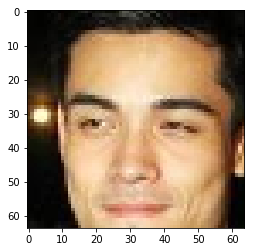

In [106]:
plt.imshow(x_celeba[5])